## The Star Dataset
##### Source: Kaggle, https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17
##### License: Data files © Original Authors
###### Note: see the link for a data dictionary to understand the variables in more detail.

### Purpose
##### Classifying luminous objects in space into either Galaxy, Quasar, Star based on spectral characteristics.

In [1]:
## The basic packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## PCA, Scaling and Under-sampling
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

## Train Test Splitting
from sklearn.model_selection import train_test_split

## KNN and K-Means Modelling packages
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

## Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

#### Stuff to fix:
##### Rephrase certain notes
##### Use PCA at which explained variance is 100%

### Reading into the star data

In [2]:
df = pd.DataFrame(pd.read_csv('Star.csv'))
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


#### Checking for null values and data types

In [3]:
## The all-in one method: '.info()'!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [4]:
df.shape

(100000, 18)

In [5]:
df['class'].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

##### There are no null entries in the dataset and most of the types are either float64 or integer64. The class is an object.

##### Changing class into an integer by mapping

In [7]:
df['class'] = df['class'].map({'GALAXY':0,'QSO':1,'STAR':2})

In [8]:
df.dtypes

obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class            int64
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object

In [9]:
df['class'].unique()

array([0, 1, 2], dtype=int64)

In [10]:
## Looking at duplicates
for x in df.duplicated():
    if x==True:
        print('Duplicated')
    else:
        continue

##### There are NO duplicated rows in the dataset. Also, the data is now all in either integer or float data type.

### Exploratory Data Analysis
##### Class is the target for all subsequent classification algorithms.


In [11]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

##### Checking for class imbalance

In [12]:
df_class = df.groupby('class').count()['obj_ID'].reset_index()

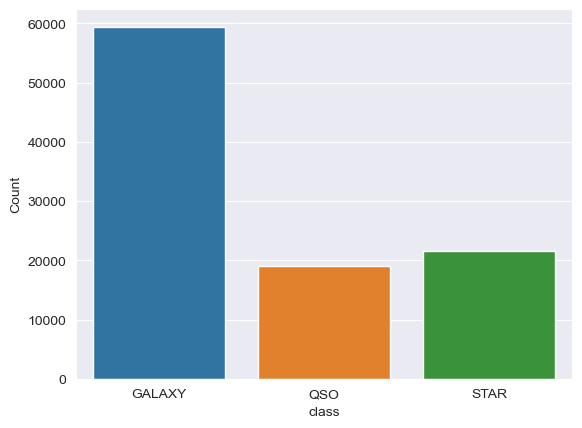

In [13]:
sns.barplot(data = df_class,
            x = 'class',
            y = 'obj_ID')
x = list(df['class'].unique())
plt.xticks(x,['GALAXY','QSO','STAR'])
plt.ylabel('Count')
plt.show()

##### We can see that galaxy is at a larger frequency compared to the others, we will use controlled undersampling provided by imblearn RandomUnderSampler()

#### Under-sampling

In [14]:
X = df[df.columns]
X.drop(columns='class',inplace=True)
y = df['class']

rus = RandomUnderSampler(random_state=0)
features_resampled, class_resampled = rus.fit_resample(X, y)

In [15]:
features_resampled.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
0,1.237659e+18,237.098640,42.403904,24.03453,22.23774,20.33128,19.48280,19.16111,3187,301,1,79,6.812993e+18,0.534005,6051,56093,628
1,1.237655e+18,195.557082,5.350464,22.75036,19.95912,18.42770,17.81463,17.42073,2247,301,5,232,5.357238e+18,0.286410,4758,55682,750
2,1.237652e+18,158.725441,2.411885,20.69054,18.94213,17.84095,17.38330,17.00193,1462,301,4,223,5.686980e+17,0.167241,505,52317,431
3,1.237668e+18,228.163700,12.374244,20.70806,19.56891,19.22142,18.56558,18.54453,5322,301,2,124,6.179045e+18,0.180778,5488,56013,387
4,1.237680e+18,341.081078,20.755188,22.72500,22.26135,21.05357,20.07774,19.62095,8108,301,4,123,6.889384e+18,0.556117,6119,56181,9


In [16]:
class_resampled.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [17]:
class_resampled.value_counts()

0    18961
1    18961
2    18961
Name: class, dtype: int64

In [18]:
### Combining the dataframes
df = pd.concat([features_resampled, class_resampled], axis=1)
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID,class
0,1.237659e+18,237.098640,42.403904,24.03453,22.23774,20.33128,19.48280,19.16111,3187,301,1,79,6.812993e+18,0.534005,6051,56093,628,0
1,1.237655e+18,195.557082,5.350464,22.75036,19.95912,18.42770,17.81463,17.42073,2247,301,5,232,5.357238e+18,0.286410,4758,55682,750,0
2,1.237652e+18,158.725441,2.411885,20.69054,18.94213,17.84095,17.38330,17.00193,1462,301,4,223,5.686980e+17,0.167241,505,52317,431,0
3,1.237668e+18,228.163700,12.374244,20.70806,19.56891,19.22142,18.56558,18.54453,5322,301,2,124,6.179045e+18,0.180778,5488,56013,387,0
4,1.237680e+18,341.081078,20.755188,22.72500,22.26135,21.05357,20.07774,19.62095,8108,301,4,123,6.889384e+18,0.556117,6119,56181,9,0


##### Need to see how many unique values there are for the columns with 'ID' suffix

In [19]:
ID = ['obj_ID', 'run_ID',
'rerun_ID', 'field_ID', 'spec_obj_ID', 'fiber_ID']
ID_l = []
Unique = []
for x in ID:
    ID_l.append(x)
    Unique.append(df[x].nunique())

dict_ = {'ID':ID_l,
         'Unique Values':Unique}
unique = pd.DataFrame(dict_)
unique

,ID,Unique Values
0,obj_ID,47332
1,run_ID,425
2,rerun_ID,1
3,field_ID,839
4,spec_obj_ID,56883
5,fiber_ID,1000


##### spec_obj_ID has the same number of unique values as the number of samples. obj_ID is close to being as much as the dataset. The rest are not close to being unique for all the samples. Thus, I will not be using spec_obj_ID.
##### Additionally, rerun_ID has only one unique value in the dataset, it will not have any predictive power and so it is removed.

In [20]:
## Dropping spec_obj_ID and rerun_ID
df.drop(columns=['spec_obj_ID','rerun_ID'],inplace=True)
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'cam_col', 'field_ID', 'redshift', 'plate', 'MJD', 'fiber_ID', 'class'],
      dtype='object')

#### Correlation plot to understand the data better.

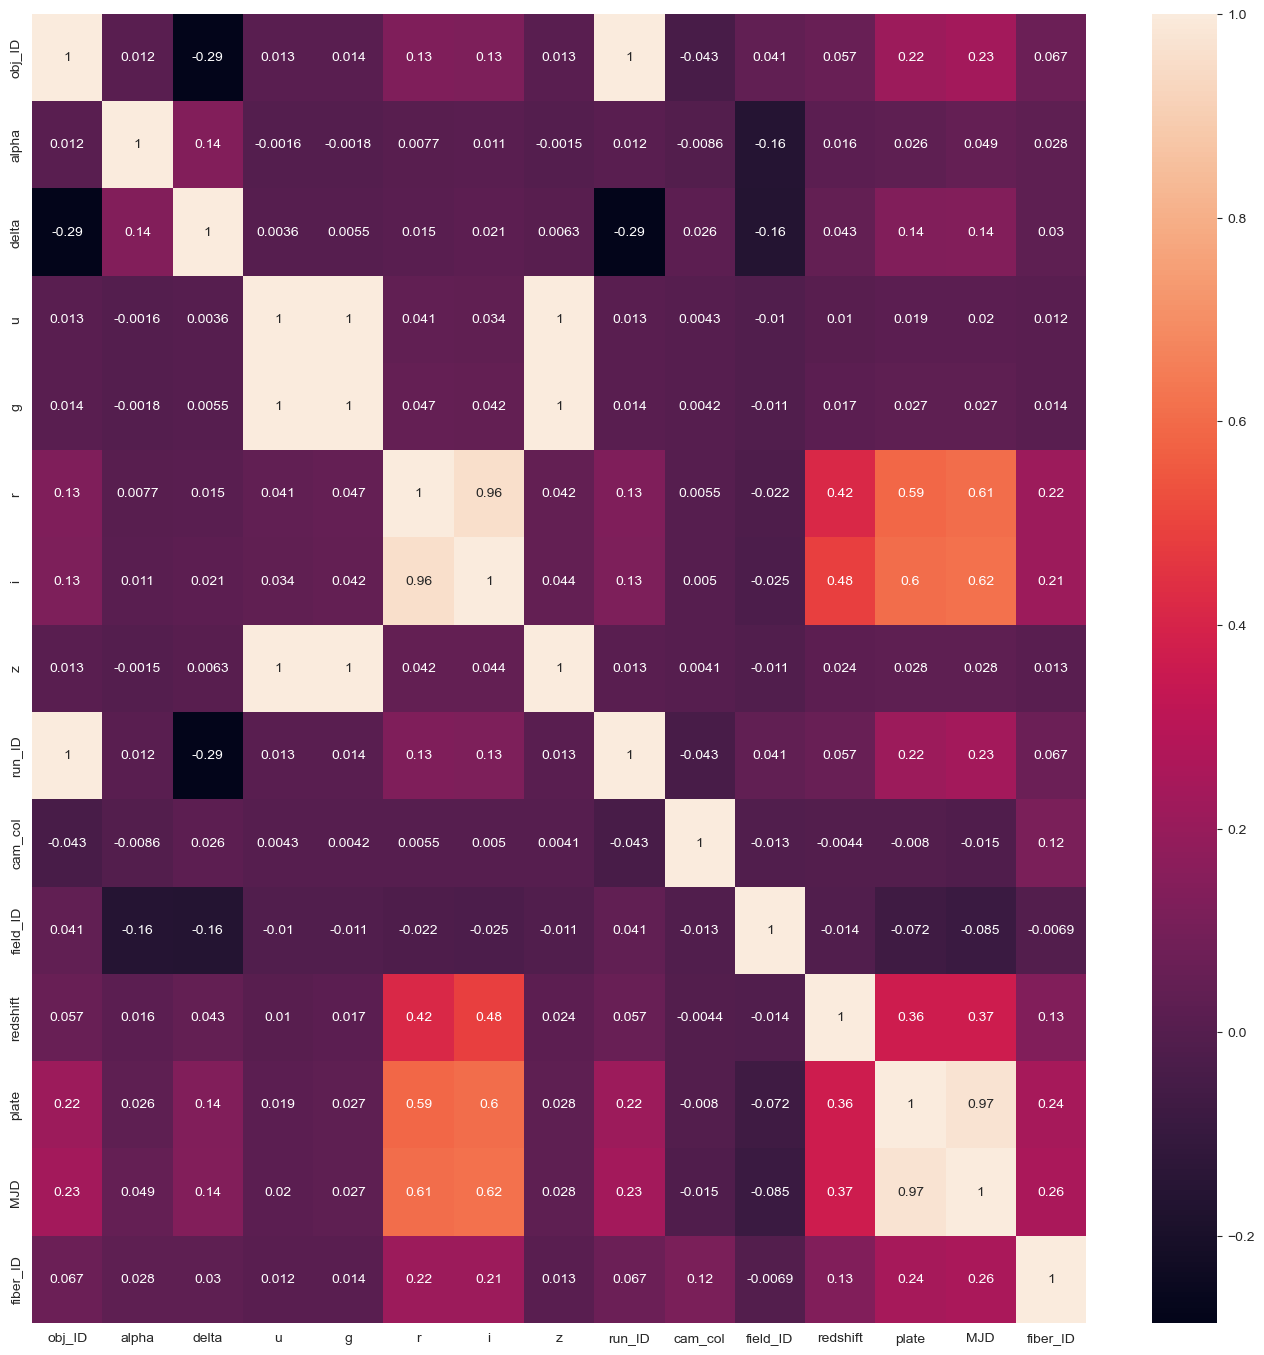

In [21]:
vars = ['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'cam_col', 'field_ID', 'redshift',
        'plate', 'MJD', 'fiber_ID']

plt.figure(figsize=(17,17))
sns.heatmap(df[vars].corr(),annot=True)
plt.show()

### Plotting
##### 3D Plotting

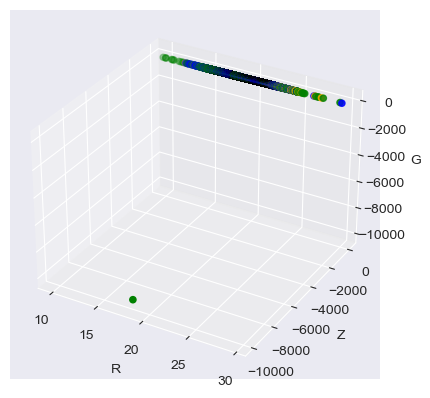

In [22]:
#Run the below if you want to rotate
#%matplotlib notebook

colors = np.array(['blue', 'orange', 'green'])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df['g']
xdata = df['r']
ydata = df['z']
ax.scatter3D(xdata, ydata, zdata, c=colors[list(df['class'])], cmap='Greens')

#Setting the labels
ax.set_zlabel('G')
ax.set_xlabel('R')
ax.set_ylabel('Z')

plt.show()

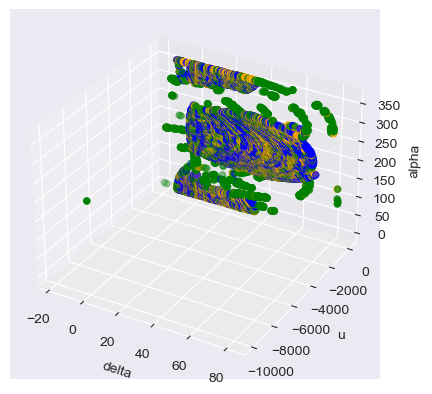

In [23]:
colors = np.array(['blue', 'orange', 'green'])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df['alpha']
xdata = df['delta']
ydata = df['u']
ax.scatter3D(xdata, ydata, zdata, c=colors[list(df['class'])], cmap='Greens')

#Setting the labels
ax.set_zlabel('alpha')
ax.set_xlabel('delta')
ax.set_ylabel('u')

plt.show()

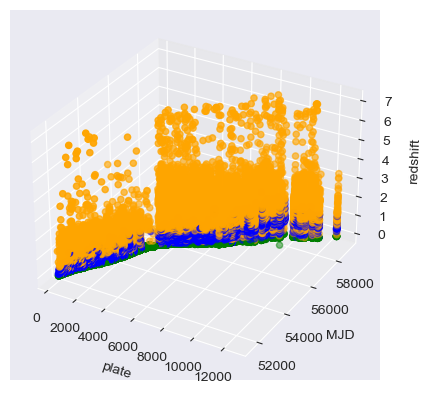

In [24]:
colors = np.array(['blue', 'orange', 'green'])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df['redshift']
xdata = df['plate']
ydata = df['MJD']
ax.scatter3D(xdata, ydata, zdata, c=colors[list(df['class'])], cmap='Greens')

#Setting the labels
ax.set_zlabel('redshift')
ax.set_xlabel('plate')
ax.set_ylabel('MJD')

plt.show()

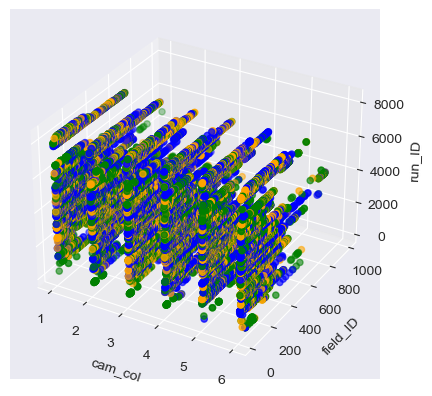

In [25]:
colors = np.array(['blue', 'orange', 'green'])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df['run_ID']
xdata = df['cam_col']
ydata = df['field_ID']
ax.scatter3D(xdata, ydata, zdata, c=colors[list(df['class'])], cmap='Greens')

#Setting the labels
ax.set_zlabel('run_ID')
ax.set_xlabel('cam_col')
ax.set_ylabel('field_ID')

plt.show()

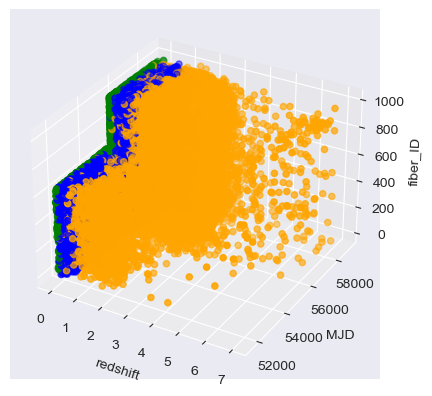

In [26]:
colors = np.array(['blue', 'orange', 'green'])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df['fiber_ID']
xdata = df['redshift']
ydata = df['MJD']
ax.scatter3D(xdata, ydata, zdata, c=colors[list(df['class'])], cmap='Greens')

#Setting the labels
ax.set_zlabel('fiber_ID')
ax.set_xlabel('redshift')
ax.set_ylabel('MJD')

plt.show()

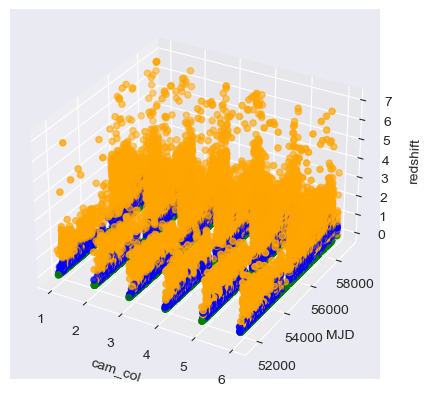

In [27]:
colors = np.array(['blue', 'orange', 'green'])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df['redshift']
xdata = df['cam_col']
ydata = df['MJD']
ax.scatter3D(xdata, ydata, zdata, c=colors[list(df['class'])], cmap='Greens')

#Setting the labels
ax.set_zlabel('redshift')
ax.set_xlabel('cam_col')
ax.set_ylabel('MJD')

plt.show()

##### Redshift seems to be a very good grouper of the different class types.

### Train Test Splitting

In [28]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'cam_col', 'field_ID', 'redshift', 'plate', 'MJD', 'fiber_ID', 'class'],
      dtype='object')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(features_resampled, class_resampled, test_size=0.20, random_state=1204, stratify=class_resampled)

In [30]:
for x in [X_train,y_train,X_test,y_test]:
    print(x.shape)

(45506, 17)
(45506,)
(11377, 17)
(11377,)


### Modelling K-Nearest Neighbours

##### First we will simply scale the data with the min max scaler and carry out K-means without PCA.

In [31]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

##### Finding the best value of K

In [79]:
errors = []
for i in range(2,15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scale,y_train)
    pred_y = knn.predict(X_train_scale)
    errors.append(np.mean(pred_y != y_train))

C:\Users\Jan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Jan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` t

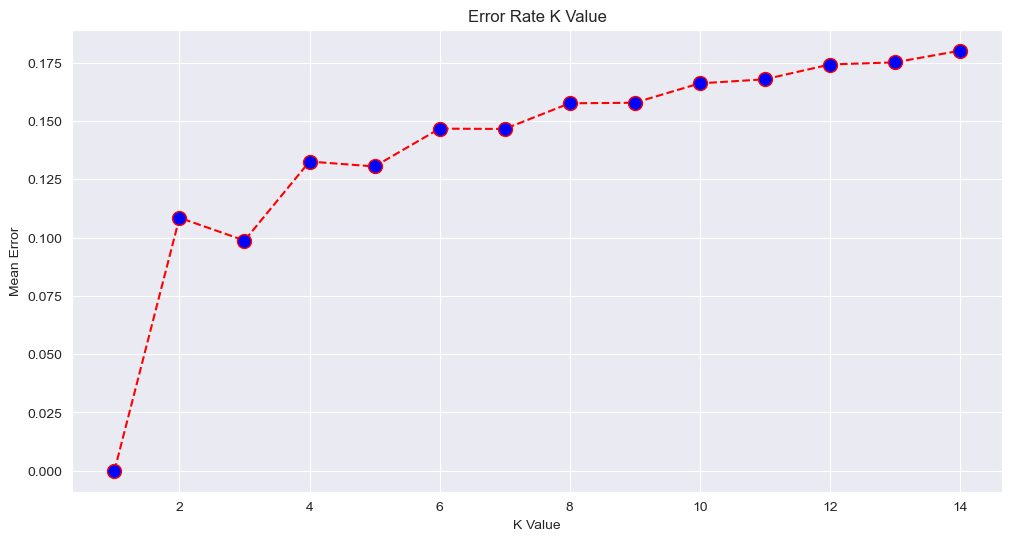

In [80]:
##Plotting to select
plt.figure(figsize=(12, 6))
plt.plot(range(2,15)
         , errors
         , color='RED'
         , linestyle='dashed'
         , marker='o'
         , markerfacecolor='blue'
         , markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

##### Getting the least amount of error when K = 3.

#### The best KNN model

In [86]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scale,y_train)
pred_y = knn.predict(X_train_scale)

C:\Users\Jan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


#### Train Data

In [87]:
print(confusion_matrix(y_train,pred_y))
print(classification_report(y_train,pred_y))

[[14104   439   626]
 [ 1448 13451   270]
 [ 1583   127 13458]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     15169
           1       0.96      0.89      0.92     15169
           2       0.94      0.89      0.91     15168

    accuracy                           0.90     45506
   macro avg       0.91      0.90      0.90     45506
weighted avg       0.91      0.90      0.90     45506



#### Test Data

In [88]:
pred_y_test = knn.predict(X_test_scale)
print(confusion_matrix(y_test,pred_y_test))
print(classification_report(y_test,pred_y_test))

C:\Users\Jan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[[3195  260  337]
 [ 517 3154  121]
 [ 777   77 2939]]
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      3792
           1       0.90      0.83      0.87      3792
           2       0.87      0.77      0.82      3793

    accuracy                           0.82     11377
   macro avg       0.83      0.82      0.82     11377
weighted avg       0.83      0.82      0.82     11377



##### The model reduced accuracy from test to train data, indicating that it has over fit. The accuracies in both cases (test/train) are above 80% which is fairly accurate. The f1-score is relatively balanced between the different classes meaning that the prediction accuracies for each group are within a roughly equal and good range.

#### PCA
##### Before we do PCA, we need to z-transform the data using Standard Scaler

In [32]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'cam_col', 'field_ID', 'redshift', 'plate', 'MJD', 'fiber_ID', 'class'],
      dtype='object')

In [33]:
z_scaler = StandardScaler()
z_scaler.fit(features_resampled)
X_scale_z = z_scaler.transform(features_resampled)

In [34]:
## Setting the number of PCA components equal to the number of features in X
pca = PCA(n_components=X_scale_z.shape[1], svd_solver = 'auto')
pca.fit_transform(X_scale_z)

array([[-3.69909208e-01, -3.22727370e-02, -1.28593060e+00, ...,
         1.81851662e-11, -4.35580041e-14,  1.18613190e-17],
       [ 1.12966373e+00, -7.66575105e-02, -8.70134862e-01, ...,
        -1.14568821e-11, -6.66569537e-14,  1.23891209e-17],
       [ 3.73449707e+00, -2.74618737e-01, -8.67399124e-01, ...,
         5.45252103e-13, -3.93057106e-16, -2.42625202e-18],
       ...,
       [ 3.68086250e+00, -1.41142044e-01,  1.62329319e-02, ...,
        -9.37711550e-12, -2.11751556e-14,  1.23111927e-19],
       [-6.18930739e-01,  4.18920439e-02, -1.44256920e+00, ...,
        -1.69451901e-11, -1.99976259e-14,  1.34297016e-19],
       [ 3.62166311e+00, -2.11244520e-01,  4.04082229e-01, ...,
        -5.40660505e-13, -1.79234401e-15, -5.02867603e-20]])

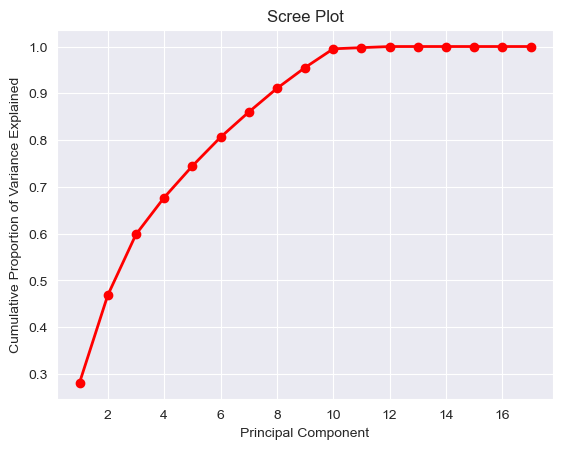

Cumulative Prop. Variance Explained:  [0.28183979 0.46861424 0.59838005 0.67721397 0.7445525  0.80609195
 0.85978605 0.91040907 0.95501702 0.99507542 0.99758145 0.99995524
 0.99999189 1.         1.         1.         1.        ]


In [35]:
#Cumulative variance explained
out_sum = np.cumsum(pca.explained_variance_ratio_)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, out_sum, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.show()

print ("Cumulative Prop. Variance Explained: ", out_sum)

##### It looks like the 6th component explains just above 80% variance. However, the 10th component explains 100% of the variance. We will use the 10 initial components for this analysis.

In [36]:
#Best PCA component number
x = 10
X_pca = PCA(n_components=x, svd_solver = 'auto').fit_transform(X_scale_z)

#### Train Test Splitting

In [37]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, class_resampled, test_size=0.20, random_state=1204, stratify=class_resampled)

In [38]:
for x in [X_train_pca, X_test_pca, y_train_pca, y_test_pca]:
    print(x.shape)

(45506, 10)
(11377, 10)
(45506,)
(11377,)


#### K-Nearest Neighbor with PCA

##### Finding the best K value

In [95]:
errors_pca = []
for i in range(2,15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_pca,y_train_pca)
    pred_y = knn.predict(X_train_pca)
    errors_pca.append(np.mean(pred_y != y_train_pca))

C:\Users\Jan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Jan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` t

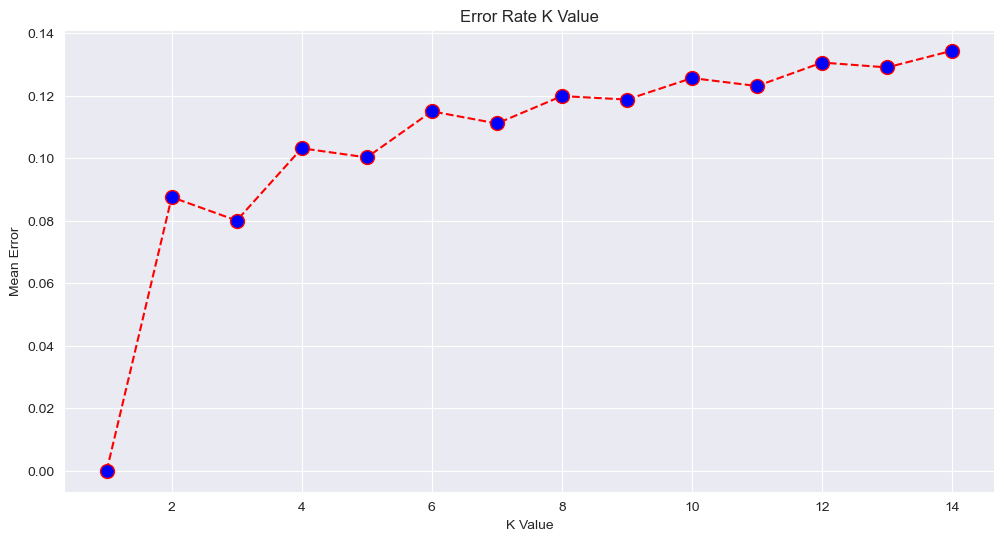

In [97]:
##Plotting to select
plt.figure(figsize=(12, 6))
plt.plot(range(2, 15)
         , errors_pca
         , color='RED'
         , linestyle='dashed'
         , marker='o'
         , markerfacecolor='blue'
         , markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

##### After PCA 10 component transformation has been applied K = 3 is the best option.

#### The best model

In [98]:
knn_pca = KNeighborsClassifier(n_neighbors=3)
knn_pca.fit(X_train_pca,y_train_pca)
pred_y_pca_train = knn_pca.predict(X_train_pca)

C:\Users\Jan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


##### Train Data

In [99]:
print(confusion_matrix(y_train_pca,pred_y_pca_train))
print(classification_report(y_train_pca,pred_y_pca_train))

[[14155   360   654]
 [ 1361 13615   193]
 [ 1056    17 14095]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     15169
           1       0.97      0.90      0.93     15169
           2       0.94      0.93      0.94     15168

    accuracy                           0.92     45506
   macro avg       0.92      0.92      0.92     45506
weighted avg       0.92      0.92      0.92     45506



##### Test Data

In [100]:
pred_y_pca_test = knn_pca.predict(X_test_pca)
print(confusion_matrix(y_test_pca,pred_y_pca_test))
print(classification_report(y_test_pca,pred_y_pca_test))

C:\Users\Jan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[[3289  189  314]
 [ 464 3244   84]
 [ 522   23 3248]]
              precision    recall  f1-score   support

           0       0.77      0.87      0.82      3792
           1       0.94      0.86      0.90      3792
           2       0.89      0.86      0.87      3793

    accuracy                           0.86     11377
   macro avg       0.87      0.86      0.86     11377
weighted avg       0.87      0.86      0.86     11377



##### There was a drop in accuracy of the model from train data to test data. Here it was less severe than the drop for KNN without PCA. The PCA data seems to have over-fit the data a lot less than non-PCA data.
##### The accuracies and f1-scores are larger for the PCA processed data. This is definitely an improvement from the previous non-PCA model.

### Unsupervised Approach: Uncovering Ideal Group Number

In [78]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'cam_col', 'field_ID', 'redshift', 'plate', 'MJD', 'fiber_ID', 'class'],
      dtype='object')

In [79]:
# Remove target = class
X_KM = df[['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'cam_col', 'field_ID', 'redshift', 'plate', 'MJD',
           'fiber_ID']]

In [80]:
## Scaling Min Max
scaler_mm = MinMaxScaler()
X_KM_scaled_mm = scaler_mm.fit_transform(X_KM)

#### K-Means

In [81]:
#Selecting K process
k_range = range(2, 10)
scores = []
inertia = []

for k in k_range:
    km3 = KMeans(n_clusters=k, random_state=124)
    km3.fit(X_KM_scaled_mm)
    scores.append(metrics.silhouette_score(X_KM_scaled_mm, km3.labels_))
    inertia.append(km3.inertia_)

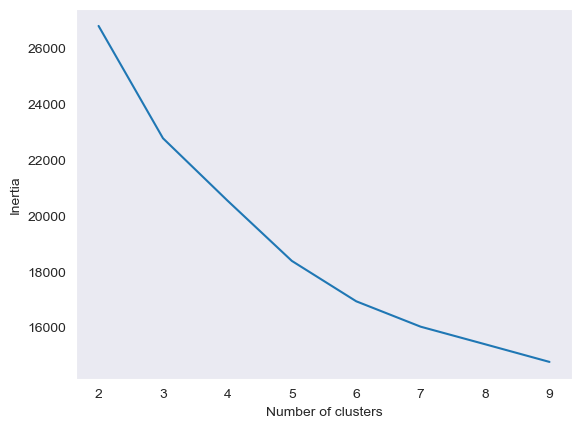

In [82]:
## Plot inertia
plt.plot(k_range, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(False)

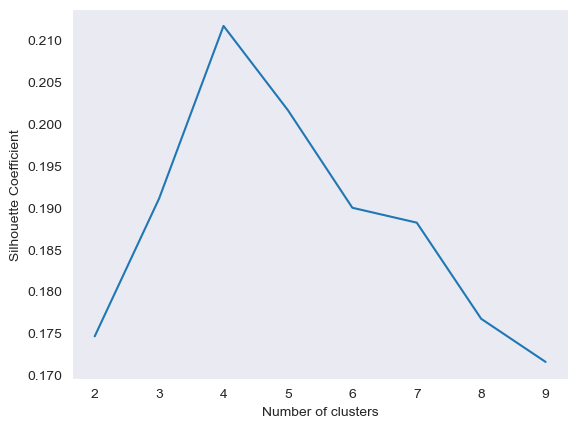

In [83]:
## Plot Silhouette score
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(False)

##### 4 clusters is gives the highest silhouette coefficient and 5 clusters gives the lowest inertia score (within cluster variability). This is already not consistent with the number of groups that we want to group for: 3 divisions of class.

#### K-Means with PCA

In [37]:
k_range = range(2, 10)
scores_pca = []
inertia_pca = []

for k in k_range:
    km3 = KMeans(n_clusters=k, random_state=124)
    km3.fit(X_pca)
    scores_pca.append(metrics.silhouette_score(X_pca, km3.labels_))
    inertia_pca.append(km3.inertia_)

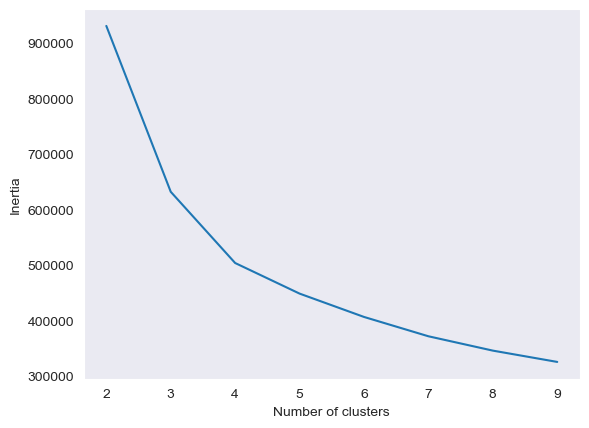

In [38]:
## Plot inertia
plt.plot(k_range, inertia_pca)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(False)

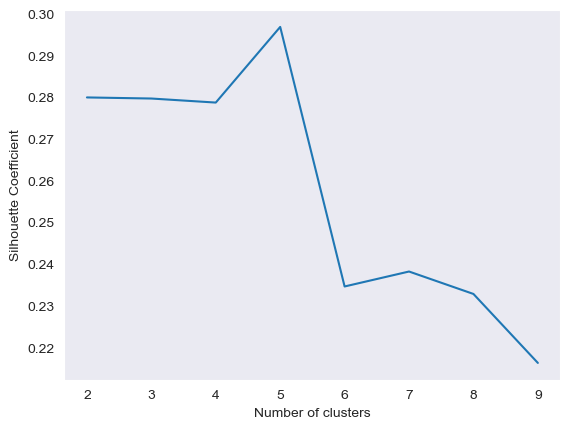

In [39]:
## Plot Silhouette Score
plt.plot(k_range, scores_pca)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(False)

##### Here the best silhouette coefficient is at K = 5 and the best inertia score is at 4 clusters. This is not consistent with the predefined class groups, again.

#### DBSCAN

In [44]:
X_DB = df[['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'cam_col', 'field_ID', 'redshift', 'plate', 'MJD',
           'fiber_ID']]
#scaler_mm = MinMaxScaler()... defined earlier
X_DB_scaled_mm = scaler_mm.fit_transform(X_DB)

In [45]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'cam_col', 'field_ID', 'redshift', 'plate', 'MJD', 'fiber_ID', 'class'],
      dtype='object')

##### Epsilon should be the decided by the elbow method of distances (explained below). Additionally, setting the number of n_neighbours to be double that of the dimensions of dataset si one of the suggested decision methods (Reference).
##### Reference: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

In [55]:
neighbors = NearestNeighbors(n_neighbors=32)
neighbors_fit = neighbors.fit(X_DB_scaled_mm)
distances, indices = neighbors_fit.kneighbors(X_DB_scaled_mm)

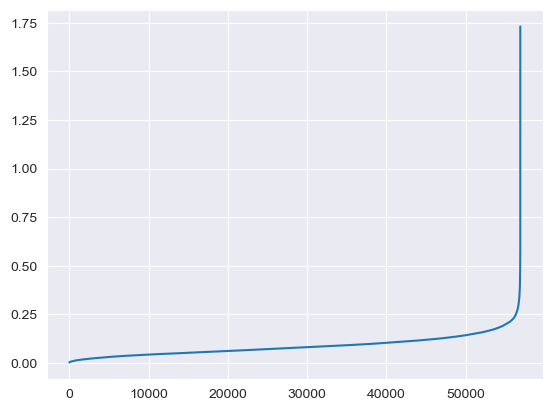

In [56]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [68]:
distances[55000]

0.19801838808716787

##### The elbow here is at roughly 0.198 which would be our epsilon value.

In [75]:
## Running DBSCAN with selected parameters based on feature number and distance plot
dbs = DBSCAN(eps=0.198,min_samples=32)
dbs.fit(X_DB_scaled_mm)
dbs.labels_

array([ 17,  16,   0, ...,  -1,  -1, 102], dtype=int64)

In [77]:
## Checking the unique labels
labels = pd.Series(dbs.labels_)
labels.unique()

array([ 17,  16,   0,   7,   1,  18,   9,  37,  -1,  55,   2,  91,   3,
         4,  42,   5,  33,   6,  22,   8,  19, 108,  45,  26,  10,  28,
        12,  52,  11,  13,  14,  15,  65,  23,  20,  21,  34,  31,  24,
        25,  58,  27,  38,  49,  29,  69,  30,  40,  74,  32, 106,  76,
        66,  35,  36, 102,  75,  64, 100,  39,  41,  48,  44,  43,  54,
        57,  46,  88,  70,  53,  97,  56,  47,  80,  77,  72,  50,  60,
        51,  79,  62,  61,  83,  86,  96,  92,  94,  73,  67, 116,  90,
        68,  71,  95,  59,  82,  84,  85,  63,  78,  81,  87,  99, 117,
        89, 105,  93, 101,  98, 110, 113, 103, 120, 114, 121, 107, 104,
       119, 122, 115, 118, 111, 109, 112], dtype=int64)

##### This is also bad since the DBSCAN created 124 groups whilst the dataset target has 3.

### Conclusions:
##### Considering the supervised modelling with K-Nearest Neighbours, the PCA treated variables that explained 100% of the variance provided very good accuracy and F1-scores. Additionally, over-fitting was not as apparent as the non_PCA version.
##### Regarding the unsupervised cluster number confirmation. The best number of clusters for the K-Means model (decided by best silhouette score) was 5. With DBSCAN, this number was 124. This is inconsistent with how many clusters there are in the supervised version of the data.
##### In effect, this suggests that the data could be grouped into more clusters providing better separation between clusters.

##### In summary, K-Nearest Neighbours models the data very well with minimal over-fitting.

### Limitations:
##### More exploration of parameter setting for models, especially for DBSCAN I would explore both epsilon and min_samples at the same time. Computational power was limited in my case, however I would use PySpark next time around.
##### More exploration of under-sampling or over-sampling techniques would be ideal. Essentially a comparison between all of them.
##### More feature selection is needed.

In [84]:
### THE END ###